 # Project: Identifying Personal Attacks in Wikipedia Comments 

# Importing librarires

In [285]:
import pandas as pd
import numpy as np
import urllib
import re
import string
import unidecode
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en import English
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

# Downloading the dataset

In [202]:
ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)
            
download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

# Reading the dataset

In [203]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [204]:
# labels a comment as an atack if the majority of annotatators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5
# join labels and comments
comments['attack'] = labels

In [205]:
comments.head()

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,False
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train,False
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train,False
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,False
93890,This page will need disambiguation.,2002,True,article,random,train,False


In [206]:
comments.describe()

,year
count,115864.000000
mean,2009.224306
std,2.900431
min,2001.000000
25%,2007.000000
50%,2009.000000
75%,2011.000000
max,2016.000000


# Data Cleaning

In [207]:
# removing newline tokens and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [208]:
# removing puctuation marks
def punctuation(text):
    return  re.sub(f'[{re.escape(string.punctuation)}]', '', text)

comments['comment'] = comments.comment.apply(punctuation)

In [209]:
# removing non-english characters and converting text to lower case
def non_english(text):
    return unidecode.unidecode(text.lower())

comments['comment'] = comments.comment.apply(non_english)

In [210]:
# removing non_alphabetic characters
def non_alphabetic(text):
    regex = re.compile('[^a-zA-Z\s]')
    return regex.sub('', text)

comments['comment'] = comments.comment.apply(non_alphabetic)


In [211]:
# removing stopwords
def remove_stopwords(text):
    sw = stopwords.words('english')
    words = [word for word in text.split() if word.lower() not in sw]
    new_text = " ".join(words)
    return new_text

comments['comment'] = comments.comment.apply(remove_stopwords)

In [212]:
comments=comments.reset_index()

In [213]:
#removing whitespaces
def remove_whitespaces(text):
    line = text.strip()
    return line
comments['comment'] = comments.comment.apply(remove_whitespaces)

In [214]:
comments['comment'][1]

'term standard model less npov think wed prefer newage speak lot oldage people speak karl popper pope etc heres karl poppers view clearest title article would particle physics cosmology say would require broader treatment issues like anthropic principle cognitive bias beyond particle physics zoo etc accelerators clear use someone still looking particles yet settled cosmology certain abandon search arbitrary foundation ontology suggest subject question'

# Lemmatization and Stemming

In [215]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def word_stemmer(words):
    stem_words = [stemmer.stem(o) for o in words]
    return " ".join(stem_words)
def word_lemmatizer(words):
    lemma_words = [lemmatizer.lemmatize(o) for o in words]
    return " ".join(lemma_words)

In [216]:
def lem_stem(dirty_text):
    clean_text = word_stemmer(dirty_text.split(" "))
    return clean_text

In [217]:
def lem(dirty_text):
    clean_text = word_lemmatizer(dirty_text.split(" "))
    return clean_text

In [218]:
comments.tail()

,rev_id,comment,year,logged_in,ns,sample,split,attack
115859,699848324,sources dont exactly exude sense impartiality ...,2016,True,article,blocked,train,False
115860,699851288,institute historical review peerreviewed journ...,2016,True,article,blocked,test,False
115861,699857133,way youre trying describe article serious step...,2016,True,article,blocked,train,False
115862,699891012,warning clearly protectionist regime going wit...,2016,True,user,blocked,dev,False
115863,699897151,alternate option perhaps enough newsworthy inf...,2016,True,article,blocked,train,False


In [219]:
len(comments)

115864

In [220]:
comments.drop(comments.index[90593:-1], inplace=True)

In [221]:
comments.drop(comments.index[-1],inplace=True)

In [223]:
comments.tail()

,rev_id,comment,year,logged_in,ns,sample,split,attack
90588,487858021,adult manifestations childhood sexual abuse al...,2012,False,user,blocked,train,False
90589,487859742,exactly problem go play games somebody else li...,2012,True,user,blocked,train,True
90590,487863318,world tomorrow jeff g feel free phone anytime ...,2012,True,user,blocked,dev,False
90591,487863449,edit warring noticeboard hi sorry bother opene...,2012,True,user,blocked,dev,False
90592,487864933,voices wonder one doesnt count proofs consensu...,2012,True,article,blocked,dev,False


In [224]:
# Increasing the limit of iterations or comparisons
import sys
sys.setrecursionlimit(1500)

In [225]:
for i in range (0, 57000):
    comments['comment'][i] = lem_stem(comments['comment'][i])

for i in range (57000, 80000):
    comments['comment'][i] = lem_stem(comments['comment'][i])
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [226]:
for i in range (80000, len(comments)):
    comments['comment'][i] = lem_stem(comments['comment'][i])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [227]:
for i in range (0, len(comments)):
    comments['comment'][i] = lem(comments['comment'][i])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [228]:
comments.tail()

,rev_id,comment,year,logged_in,ns,sample,split,attack
90588,487858021,adult manifest childhood sexual abus allianc a...,2012,False,user,blocked,train,False
90589,487859742,exactli problem go play game somebodi el littl...,2012,True,user,blocked,train,True
90590,487863318,world tomorrow jeff g feel free phone anytim w...,2012,True,user,blocked,dev,False
90591,487863449,edit war noticeboard hi sorri bother open anot...,2012,True,user,blocked,dev,False
90592,487864933,voic wonder one doesnt count proof consensu ma...,2012,True,article,blocked,dev,False


# Data Visualization

In [229]:
comments['attack'].value_counts()

False    79738
True     10855
Name: attack, dtype: int64

In [230]:
comments['year'].unique()

array([2002, 2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012])

Text(0.5, 1.0, 'Attack v/s Non-Attack')

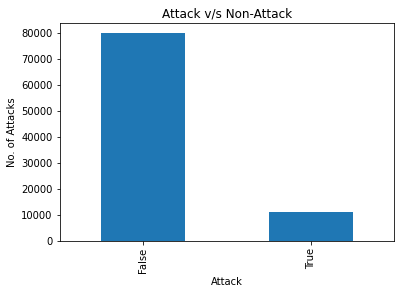

In [231]:
comments.groupby('attack').size().plot(kind='bar', xlabel='Attack', ylabel='No. of Attacks')
plt.title('Attack v/s Non-Attack')

In [232]:
total_years = comments[comments['attack'] == False].groupby('year')['attack'].count()

Text(0.5, 1.0, 'Attack v/s Year')

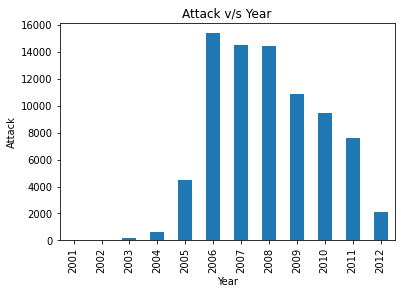

In [233]:
total_years.plot(kind='bar', xlabel='Year', ylabel='Attack')
plt.title('Attack v/s Year')

In [234]:
total_users = comments[comments['logged_in'] == True].groupby('attack')['logged_in'].count()

Text(0.5, 1.0, 'Attack v/s Logged_In')

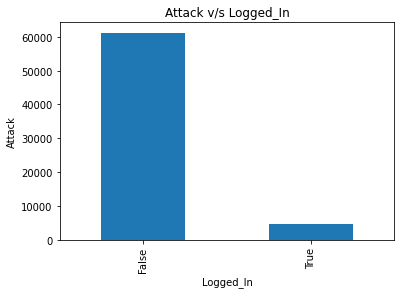

In [235]:
total_users.plot(kind='bar', xlabel='Logged_In', ylabel='Attack')
plt.title('Attack v/s Logged_In')

# Feature Extraction

In [236]:
c_list = comments['comment']

In [237]:
vocabulary = []

In [238]:
for i in c_list:
    for j in i.split():
        if j not in vocabulary:
            vocabulary.append(j)

In [239]:
comments.head()

,rev_id,comment,year,logged_in,ns,sample,split,attack
0,37675,creativ dictionari definit term insur ensur pr...,2002,False,article,random,train,False
1,44816,term standard model le npov think wed prefer n...,2002,False,article,random,train,False
2,49851,true fals situat march saudi propos land peac ...,2002,False,article,random,train,False
3,89320,next mayb could work le condescend suggest rea...,2002,True,article,random,dev,False
4,93890,page need disambigu,2002,True,article,random,train,False


In [240]:
X = comments['comment']
Y = comments['attack']
# Y=Y.astype('int')

In [241]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

In [242]:
x_train,x_test , y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [243]:
x_train.shape

(72474, 119638)

# K fold Cross Validation
### k = 10

In [267]:
# A function for cross valication
def cross_validation(model, _X, _y, _cv=10):
    _scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
    return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

# Model 1 : Logistic Regression

In [245]:
log_reg = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
log_reg.fit(x_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [246]:
LR_res = log_reg.predict(x_test)

In [247]:
print(classification_report(LR_res, y_test))

              precision    recall  f1-score   support

       False       0.95      0.97      0.96     15515
        True       0.78      0.67      0.72      2604

    accuracy                           0.93     18119
   macro avg       0.86      0.82      0.84     18119
weighted avg       0.92      0.93      0.92     18119



In [248]:
#Confusion matrix
cf_matrix_LR = confusion_matrix(y_test, LR_res)
print(cf_matrix_LR)

[[15025   853]
 [  490  1751]]


<AxesSubplot:>

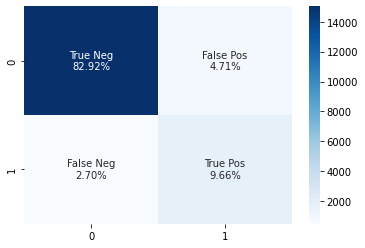

In [249]:
# Plotting Confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_LR.flatten()/np.sum(cf_matrix_LR)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_LR, annot=labels, fmt='', cmap='Blues')

In [270]:
print(cross_validation(log_reg, X, Y))

{'Training Accuracy scores': array([0.96807428, 0.96831958, 0.96784124, 0.96800108, 0.96812373,
       0.96829544, 0.96846714, 0.96825864, 0.96839355, 0.96811146]), 'Mean Training Accuracy': 96.81886136275602, 'Training Precision scores': array([0.80154856, 0.802492  , 0.80067312, 0.80055402, 0.8013785 ,
       0.80171328, 0.80316685, 0.80242547, 0.80305073, 0.80210704]), 'Mean Training Precision': 0.8019109560803033, 'Training Recall scores': array([0.97492067, 0.97573958, 0.97410175, 0.97615148, 0.97584442,
       0.97707267, 0.97604913, 0.9752303 , 0.97543249, 0.97420412]), 'Mean Training Recall': 0.9754746611935294, 'Training F1 scores': array([0.87977461, 0.88067631, 0.87891383, 0.87967532, 0.880048  ,
       0.88074918, 0.8812087 , 0.88042876, 0.88088745, 0.8798188 ]), 'Mean Training F1 Score': 0.8802180956840955, 'Validation Accuracy scores': array([0.92373068, 0.92251656, 0.92317881, 0.9242742 , 0.92096258,
       0.91687824, 0.93056629, 0.91930677, 0.93023513, 0.92968319]), 'M

# Model 2 : Multinomial Naive Bayes

In [251]:
NB = MultinomialNB()
NB.fit(x_train, y_train)

MultinomialNB()

In [252]:
NB_res = NB.predict(x_test)

In [253]:
print(classification_report(NB_res, y_test))

              precision    recall  f1-score   support

       False       0.97      0.94      0.96     16379
        True       0.58      0.75      0.65      1740

    accuracy                           0.92     18119
   macro avg       0.78      0.84      0.80     18119
weighted avg       0.93      0.92      0.93     18119



In [254]:
#Confusion matrix
cf_matrix_NB = confusion_matrix(y_test, NB_res)
print(cf_matrix_NB)

[[15435   443]
 [  944  1297]]


<AxesSubplot:>

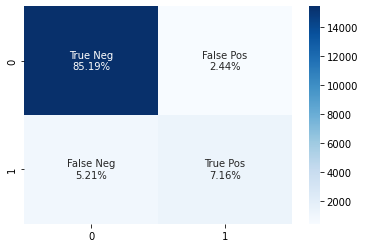

In [255]:
#Plotting confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_NB.flatten()/np.sum(cf_matrix_NB)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_NB, annot=labels, fmt='', cmap='Blues')

In [256]:
# Cross validation for Naive bayes
print(cross_validation(NB, X, Y))

{'Training Accuracy scores': array([0.94225651, 0.94204801, 0.941631  , 0.9414968 , 0.94197513,
       0.94201192, 0.9412515 , 0.94187701, 0.94116565, 0.94143547]), 'Mean Training Accuracy': 94.17148992267161, 'Training Precision scores': array([0.82867905, 0.82275403, 0.82899921, 0.82894737, 0.824636  ,
       0.82237852, 0.81376008, 0.825042  , 0.82411995, 0.83020365]), 'Mean Training Precision': 0.8249519851403418, 'Training Recall scores': array([0.65308629, 0.65810216, 0.6461255 , 0.64483112, 0.65506653,
       0.65823951, 0.66100307, 0.65353122, 0.64704678, 0.6426451 ]), 'Mean Training Recall': 0.6519677277976949, 'Training F1 scores': array([0.73047859, 0.73127453, 0.72622677, 0.7253886 , 0.73013519,
       0.73121092, 0.72947024, 0.7293392 , 0.72492689, 0.72448214]), 'Mean Training F1 Score': 0.7282933057557852, 'Validation Accuracy scores': array([0.9192053 , 0.91898455, 0.92593819, 0.92261839, 0.92283917,
       0.92913125, 0.92891048, 0.92394304, 0.92703389, 0.92085219]), 'M

# Model 3 : Random Forest Classifier

In [271]:
RF = RandomForestClassifier()
RF.fit(x_train, y_train)

RandomForestClassifier()

In [272]:
RF_res = RF.predict(x_test)

In [273]:
print(classification_report(RF_res, y_test))

              precision    recall  f1-score   support

       False       0.99      0.94      0.96     16767
        True       0.54      0.89      0.67      1352

    accuracy                           0.93     18119
   macro avg       0.76      0.91      0.82     18119
weighted avg       0.96      0.93      0.94     18119



In [274]:
#Confusion matrix
cf_matrix_RF = confusion_matrix(y_test, RF_res)
print(cf_matrix_RF)

[[15728   150]
 [ 1039  1202]]


<AxesSubplot:>

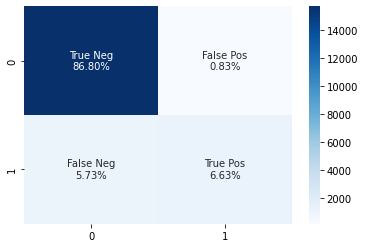

In [275]:
# Plotting the confusin matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_RF.flatten()/np.sum(cf_matrix_RF)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_RF, annot=labels, fmt='', cmap='Blues')

In [290]:
# Cross validation for Random Forest Classifier
print(cross_validation(RF, x_train, y_train))

{'Training Accuracy scores': array([0.99961672, 0.99954006, 0.99954006, 0.99952473, 0.99958606,
       0.99960139, 0.99960139, 0.99949407, 0.99947874, 0.99961672]), 'Mean Training Accuracy': 99.95599954337439, 'Training Precision scores': array([0.99883796, 0.99883721, 0.99870834, 0.99896601, 0.99845161,
       0.99909572, 0.99922471, 0.99870801, 0.99857899, 0.99832345]), 'Mean Training Precision': 0.9987732015135519, 'Training Recall scores': array([0.99793602, 0.99729102, 0.99742002, 0.99703302, 0.99806527,
       0.99754934, 0.99742035, 0.99703341, 0.99703341, 0.99845221]), 'Mean Training Recall': 0.9975234061664203, 'Training F1 scores': array([0.99838678, 0.99806352, 0.99806377, 0.99799858, 0.9982584 ,
       0.99832193, 0.99832171, 0.99787001, 0.9978056 , 0.99838782]), 'Mean Training F1 Score': 0.9981478127383185, 'Validation Accuracy scores': array([0.93529249, 0.9334989 , 0.93460265, 0.93543046, 0.93983717,
       0.9372154 , 0.93569753, 0.93887126, 0.93473161, 0.9348696 ]), 'M

# Hyperparameter Tuning

In [194]:
model = log_reg
grid_vals = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1]}
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='accuracy', 
                       cv=6, refit=True, return_train_score=True, verbose=10) 

In [195]:
#Training and Prediction

grid_lr.fit(x_train, y_train)
preds = grid_lr.best_estimator_.predict(x_test)

Fitting 6 folds for each of 8 candidates, totalling 48 fits
[CV 1/6; 1/8] START C=0.001, penalty=l1.........................................
[CV 1/6; 1/8] END C=0.001, penalty=l1;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/6; 1/8] START C=0.001, penalty=l1.........................................
[CV 2/6; 1/8] END C=0.001, penalty=l1;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/6; 1/8] START C=0.001, penalty=l1.........................................
[CV 3/6; 1/8] END C=0.001, penalty=l1;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/6; 1/8] START C=0.001, penalty=l1.........................................
[CV 4/6; 1/8] END C=0.001, penalty=l1;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/6; 1/8] START C=0.001, penalty=l1.........................................
[CV 5/6; 1/8] END C=0.001, penalty=l1;, score=(train=nan, test=nan) total time=   0.0s
[CV 6/6; 1/8] START C=0.001, penalty=l1.........................................
[CV 6/6; 1/8] END C

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.

In [372]:
print(grid_lr.best_params_)

{'C': 1, 'penalty': 'l2'}


In [343]:
model = LogisticRegression(penalty='l2', C=1, max_iter=10000).fit(x_train,y_train)
print (f'Accuracy - : {grid_lr.score(x_train,y_train):.3f}')

Accuracy - : 0.969


# Question and Answers

a.What did you learn from visualizing the data as suggested in Section 2 above?

After visualizing the data I found out that :

1)Users made more attck comments when they were not logged in

2)Majority of the attack comments were seen in the year 2006

3)There are more non-attack comments compared to attack comments in the dataset

b. What text cleaning methods did you try? Which are the ones you included in the final code?

I have tried variety of text cleaning methods :

1)Removing newline tokens and tab tokens

2)Removing punctuations

3)Removing unicode characters

4)Removing non-alphabetic characters

5)Removing whitespaces

6)Removing stopwords

c. What are the features you considered using? Which features did you use in the final code? 

After visualizing the data I found that comments is the main feature that needs to be considered for building the model hence I only used the comments feature from the dataset

d. How did you decide to use the ‘attack’ information from different annotators? Did you average them, or use a number threshold, or did you use some other method to use this information?

I followed the same method that was given in the strawman code where the mean was taken and if 50% of annotators told it was an attack then it was considered an attack or vice-versa

e. Did you add any special optimizations to your code? If so, describe them briefly.

Yes, I did add Lemmatization and Stemming which helped me increase the accuracy of my model
Lemmatization is a term that means grouping words which have the same root but different derivatives.For instance, to lemmatize the words 'cards' means taking away the suffix 's' to bring the root word 'card'.
Stemming is the process of removing variants of a base word. For example, the word 'study' has many forms like 'studies', 'studying','studied' it converts the word to the base form.

f. What are the ML methods you tried out, and what were your best results with each method? 
Which was the best ML method you saw before tuning hyperparameters?

I tried five ML Models :

1)Logistic Regression

2)Multinomial Naive Bayes

3)Random Forest Classifier

4)SGD Classifier

5)Perceptron

6)KNeighbours Classifier

Out of which I finalized the first 3 for my final code and achieved the best results via Logistic Regression.

g. What hyperparameter tuning did you do, and by how many percentage points did your accuracy 
go up because of hyper-parameter tuning?  

I performed hyperparemetre tuning on the best model which is Logistic Regression. I performed tuning using Grid Search CV. My accuracy incresed by 3%

h. What did you learn from the different metrics? How useful was it to use cross-validation?

The base metric used for model evaluation is accuracy which describes the number of correct predictions over all predictions but it is not the best metric to be considered.
Precision is a measure of how many of the positive predictions made are correct which is the true positives.
Recall is a measure of how many of the positive cases the model predicted correctly.
F1-Score is a measure combining both precision and recall. It is generally described as the harmonic mean/average of the Precison and Recall. I used F1 score to analyze and predict how good my model is while looking at the metrics. Cross validation helped me test the model's accuracy by providing a range of accuracy scores across different data sets. I took k = 10 which divided the dataset into 10 folds.

i. What are your best final Result Metrics? What is the increase in accuracy compared to the 
strawman figure? Which model gave you this performance?

               precision    recall  f1-score   support

       False       0.95      0.97      0.96     15515
        True       0.78      0.67      0.72      2604

    accuracy                            0.93     18119
    macro avg       0.86      0.82      0.84     18119
    weighted avg    0.92      0.93      0.92     18119


The above metrics are from Logistic Regression which I have considered as the best model and the below metrics are from the strawman code using Decison Tree Classifier. The F1 score as well as the accuracy has increased.

                precision    recall  f1-score   support

       False       0.95      0.95      0.95     20422
        True       0.65      0.62      0.63      2756

    accuracy                            0.91     23178
    macro avg       0.80      0.79      0.79     23178
    weighted avg    0.91      0.91      0.91     23178

j. What is the most interesting thing you learned from doing the report?

The thing I enjoyed was trying out different models and looking at the metrics and comparing them to find out the best one. While finalizing the code I had to remove and cut down a lot of cells which made me realise that so much has to be done to reach the finl result and conclusion.

k. What was the hardest thing to do?

Faced difficulty with Hyperparametre Tuning and it did consume a lot of time. 